# IAQ and Fitbit-Measured Sleep Exploration
Arguably the main attraction (for me at least), we explore the effect of IAQ parameters on Fitbit-measured sleep parameters.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Nightly Pollutant Exposures and Sleep Quality
The purpose of this notebook is to look at the in-depth relationships between IAQ and sleep quality, some of which has already been looked at in another notebook which has been copied here.

In [39]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates
from joypy import joyplot

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# Data Import
For this analysis we need all reports of sleep quality in addition to the IEQ data and ventilation rates

### Fitbit Sleep Summary

In [3]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"])#,index_col=["beiwe","start_time"])
fb_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,...,efficiency,end_time,start_time,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
0,2020-05-14,2020-05-14,5,84,20,213,10,82,21,27,...,97,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25,0.400000,297,0.276094,6.766667
1,2020-05-14,2020-05-15,4,95,31,250,6,47,33,101,...,87,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35,0.171429,345,0.136232,8.216667
2,2020-05-15,2020-05-16,2,47,17,190,8,50,20,42,...,95,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19,0.421053,237,0.210970,5.483333
3,2020-05-17,2020-05-17,5,78,21,242,11,83,25,44,...,96,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26,0.423077,320,0.259375,7.450000
4,2020-05-18,2020-05-18,5,96,20,167,14,88,28,65,...,92,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25,0.560000,263,0.334601,6.933333


### Self-Report Sleep

In [4]:
beiwe_sleep = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"])
beiwe_sleep.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN
4,2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN


### Beacon IAQ
And lastly the IAQ measurements courtesy of the beacons

In [5]:
ieq_raw = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time",])
ieq_raw.drop([c for c in ieq_raw.columns if c.endswith("percent") or c.endswith("mean")],axis="columns",inplace=True)
for bad_label in ["long","lat","accuracy","altitude","rh","lux","pm1","number"]:
    ieq_raw.drop([c for c in ieq_raw.columns if c.startswith(bad_label)],axis="columns",inplace=True)

ieq = ieq_raw.copy()
ieq.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,tvoc_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,NaN,10.359917,1600.754959,0.914249,0.895571,23.337500,91.90,NaN,0.731650,304.035761,1.960803,0.620298,1.000
1,2020-08-11 03:35:00,2020-08-11 12:36:30,21,lkkjddam,25,12,233.566667,NaN,6.429275,1628.474180,1.287357,0.847762,25.000000,160.45,NaN,5.565250,202.651343,6.086460,0.665257,1.650
2,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,NaN,10.271850,1596.122408,2.879650,0.939256,24.000000,108.60,NaN,0.512533,146.009840,5.472740,0.702017,0.000
3,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,NaN,7.232700,1301.449844,1.232406,0.886675,25.000000,81.80,NaN,5.108383,233.372161,3.742991,0.736714,1.175
4,2020-08-15 06:51:30,2020-08-15 11:30:00,21,lkkjddam,25,12,209.600000,NaN,10.886100,1274.110350,2.017288,1.046326,23.333333,149.30,NaN,0.684917,125.544723,43.415611,2.880943,1.000


# Fitbit-Measured Sleep
We start by looking at the response in Fitbit-measure sleep metrics

## Grouping Nights by Concentration
We can group each of the nights based on the median concentration value for each pollutant can compare that to sleep quality. However, to do so requires that we establish thresholds for low and high concentrations:
- **TVOCs**: The "short and long-term" [recommendation by the WHO](https://iaqscience.lbl.gov/voc-intro) is 200 ppb so `tvoc_threshold=200`
- **NO$_2$**: EPA provides outdoor standards where the most strict standard is the annual exposure limit at 53 ppb. The EPA's [discussion on indoor](https://www.epa.gov/indoor-air-quality-iaq/nitrogen-dioxides-impact-indoor-air-quality) NO$_2$ states that indoor concentration "[are] about half that of outdoors." Therefore, we will set `no2_threshold=26`. 
- **CO**: The WHO published a [study on CO guidelines](https://www.ncbi.nlm.nih.gov/books/NBK138710/) and recommended as low as 4.6 mg/m$^3$ which is approximately 4 ppm so `co_threshold=4`
- **CO$_2$**: [OSHA](https://ohsonline.com/Articles/2016/04/01/Carbon-Dioxide-Detection-and-Indoor-Air-Quality-Control.aspx?m=1&Page=2) and ASHRAE generally agree that concentrations above 1000 ppm tend to create some issues so `co2_threshold=1000`
- **PM2.5** (mass): Considering the EPA again, the outdoor annual exposure limit is 12 $\mu$g/m$^3$ and the [EPA mentions](https://www.epa.gov/indoor-air-quality-iaq/indoor-particulate-matter#Levels_in_Homes) that concentrations indoors would mirror outdoor concentrations absent of any indoor sources so `pm2p5_mass_threshold=12`
- **Temperature**: The ideal temperature range is between 60-67F which is lower than the minimum temperature that was measured. So we will use 80F as a lower threshold and then increase slightly for the extra heat from the sensors so `temperature_c_threshold=27`

### Visualizing and Running T-Test on Sleep Metrics
Now we can look at the distribution of sleep metrics for each pollutant profile and run a T-Test to see if there are _significant_ differences between the sleep metric results.

In [6]:
def run_ttest_ieq_and_sleep(df, pollutants=["tvoc","no2","co","co2","pm2p5_mass","temperature_c"], limits=[200,26,4,1100,1.5,27], sleep_metrics=["tst_fb","rem2nrem_minutes","efficiency"], pollutant_metric="median", showfig=True, save=False):
    """
    
    """
    df_to_plot = df.copy()
    # adding "low"/"high" column for each pollutant
    thresholds = dict(zip(pollutants,limits))
    for pollutant, threshold in thresholds.items():
        df_to_plot[f"{pollutant}_level"] = np.where(df_to_plot[f"{pollutant}_{pollutant_metric}"] < threshold, "low","high")
    # creating dictionary to store p-values
    ttest_results = {}
    # looping through sleep metrics
    for sleep_metric in sleep_metrics:
        print(f"Running for: {sleep_metric.split('_')[0]}")
        # expanding the df to allow for easier plotting
        df_expanded = df_to_plot.melt(id_vars=[c for c in df_to_plot.columns if c.endswith("median") or c == sleep_metric],value_vars=[c for c in df_to_plot.columns if c.endswith("level")],value_name="level")
        # plotting
        fig,ax = plt.subplots(figsize=(16,6))
        sns.violinplot(x="variable",y=sleep_metric,hue="level",data=df_expanded,split=True,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},inner="quartile",cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([pollutant.split("_")[0].upper().replace("O2","O$_2$").replace("2P5","$_{2.5}$").replace(" C","").replace("TEMPERATURE","T") for pollutant in pollutants],fontsize=14)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=14)
        if sleep_metric not in ["efficiency"]:
            ax.set_ylabel(sleep_metric.split("_")[0].replace("2",":").upper().replace("N","n"),fontsize=16)
        else:
            ax.set_ylabel(sleep_metric.title(),fontsize=16)
        # Modifying Remainder
        ax.legend(bbox_to_anchor=(1.1,0.75),frameon=False,ncol=1,fontsize=12,title_fontsize=14,title="Median\nConcentration")
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        pvals = pd.DataFrame()
        for pollutant in pollutants:
            df = df_expanded[df_expanded["variable"] == f"{pollutant}_level"]
            low_vals = df[df["level"] == "low"]
            high_vals = df[df["level"] == "high"]
            _, p = stats.ttest_ind(low_vals[sleep_metric],high_vals[sleep_metric], equal_var=True)
            pvals = pvals.append(pd.DataFrame({"pollutant":[pollutant],"low":[len(low_vals)],"high":[len(high_vals)],"p_val":[p]}))

        ttest_results[sleep_metric.split("_")[0]] = pvals.set_index("pollutant")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=12)
        for xloc, p in zip(xlocs,ttest_results[sleep_metric.split("_")[0]]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            ax.text(xloc,ax.get_ylim()[1],round(p,3),fontsize=12,ha="center",va="bottom",weight=weight)
            
        if save:
            plt.savefig(f'../../papers/5eea5276044b790001ee5687/figures/beacon-fitbit-{pollutant_metric}_profile-{sleep_metric}-ux_s20.pdf',bbox_inches="tight")
            plt.savefig(f'../reports/figures/beacon_fitbit/beacon-fitbit-{pollutant_metric}_profile-{sleep_metric}-ux_s20.png',bbox_inches="tight")

        if showfig:
            plt.show()
            plt.close()
            
    return ttest_results
    

Running for: tst


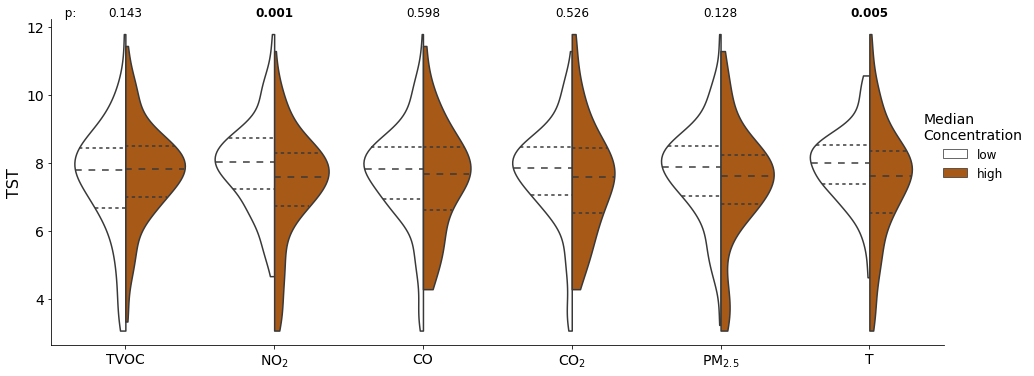

Running for: rem2nrem


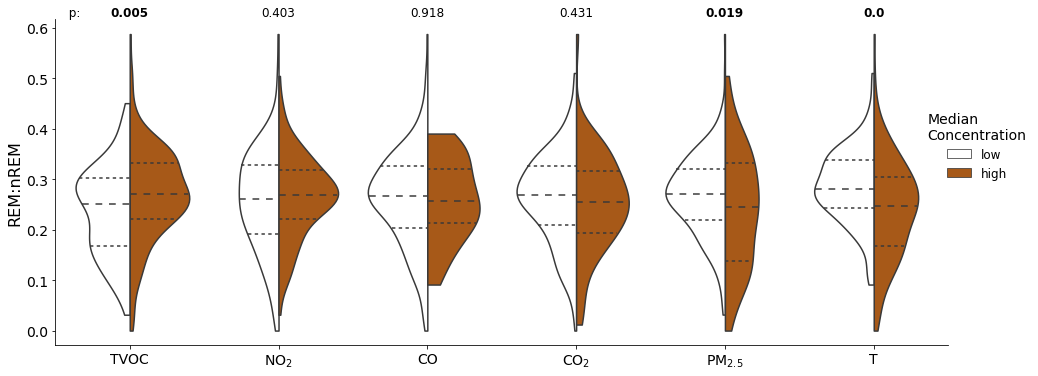

Running for: efficiency


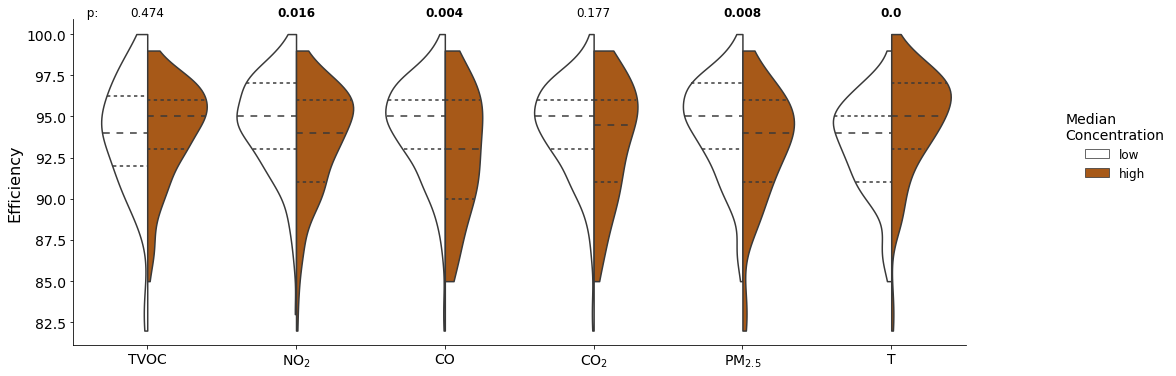

In [7]:
ieq_and_fb_sleep = ieq.merge(right=fb_sleep,on=["start_time","beiwe"])
ieq_and_fb_sleep = ieq_and_fb_sleep[ieq_and_fb_sleep["efficiency"] >= 70]
ttest_results = run_ttest_ieq_and_sleep(ieq_and_fb_sleep,save=False)

## Ventilation
Now we look at the relationship between ventilation and sleep metrics

# Self-Report Sleep Metrics
Next, we see how the results change if we consider self-report sleep metrics.

## Merging Datasets

In [8]:
beiwe_sleep["end_date"] = beiwe_sleep["timestamp"].dt.date
ieq["end_date"] = ieq["end_time"].dt.date
ieq_and_bw_sleep = ieq.merge(right=beiwe_sleep, on=["end_date","beiwe","redcap","beacon"])

## Pre-Processing
There are a few tweaks to the original dataset that we want to make.

### Binary Restful Score
We can group the restfulness score into a binary output:
* negative: 0 or 1
* positive: 2 or 3

In [17]:
ieq_and_bw_sleep["restful_binary"] = ["Positive" if score > 1 else "Negative" for score in ieq_and_bw_sleep["restful"]]

### Three-Point Scale
Since the lowest `restful` score has so few respondents, we can group the restfulness scores into three bins which also normalizes the largest bin as the middle score (which is probably more accurate).

In [38]:
ieq_and_bw_sleep["restful_three"] = [score if score != 0 else 1 for score in ieq_and_bw_sleep["restful"]]

## Restfulness Scores
Restfulness scores lend themselves to some analysis on the concentrations by grouping by score

### Joyplots
We can construct some joyplots to get a sense of the data we have.

In [9]:
def plot_joyplot(df, pollutant_aggregate, by_var="restful", save=False, save_dir="../reports/figures/beacon_ema"):
    """Joyplot of pollutant aggregate profile for various restful scores"""
    c = df[by_var].value_counts().sort_index()
    new_labels = []
    for i, count in enumerate(c):
        new_labels.append(f"{i} ({count})")
    _, axes = joyplot(data=df,by=by_var,column=pollutant_aggregate,
                kind='kde',overlap=1,ylim='own',grid="y",labels=[""]*len(c),alpha=1,linewidth=2,colormap=LinearSegmentedColormap.from_list("", ["white","cornflowerblue"]),figsize=(8,6))
    agg = pollutant_aggregate.split("_")[-1]
    axes[-1].set_xlabel(f"Nightly {pollutant_aggregate.split('_')[-1].title()} {visualize.get_pollutant_label(pollutant_aggregate.split(f'_{agg}')[0])} Concentration ({visualize.get_pollutant_units(pollutant_aggregate.split(f'_{agg}')[0])})", fontsize=18)
    for ax, label in zip(axes, new_labels):
        ax.set_ylabel(label, rotation=0, va="top", fontsize=14)
        ax.set_xlim(left=0)
        
    plt.xticks(fontsize=14)
    fig.text(-0.1,0.5,"Restful Score (n)", va="center",fontsize=18,rotation=90)
    if save:
        plt.savefig(f"{save_dir}/{pollutant_aggregate}-{by_var}-joyplot.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

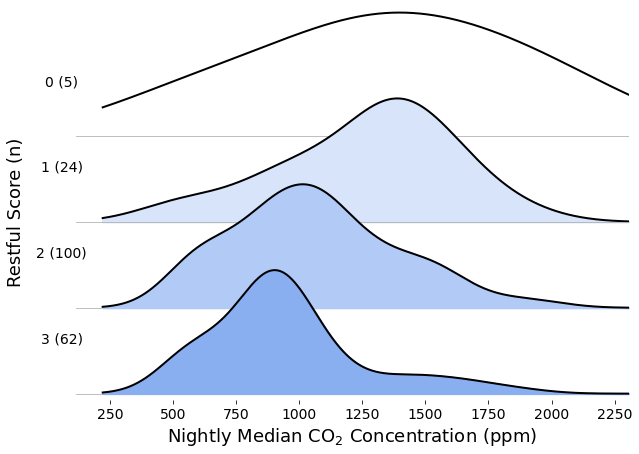

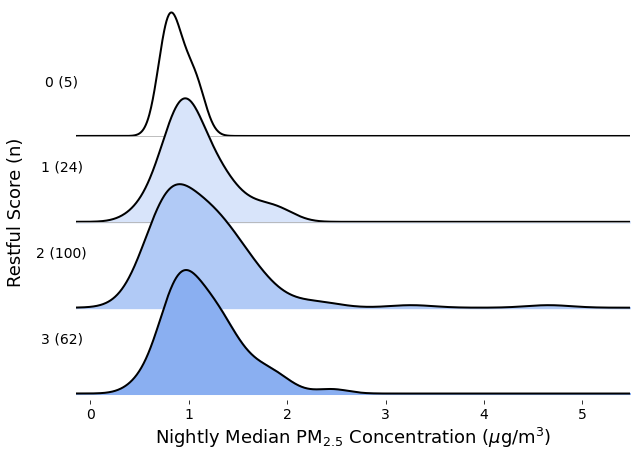

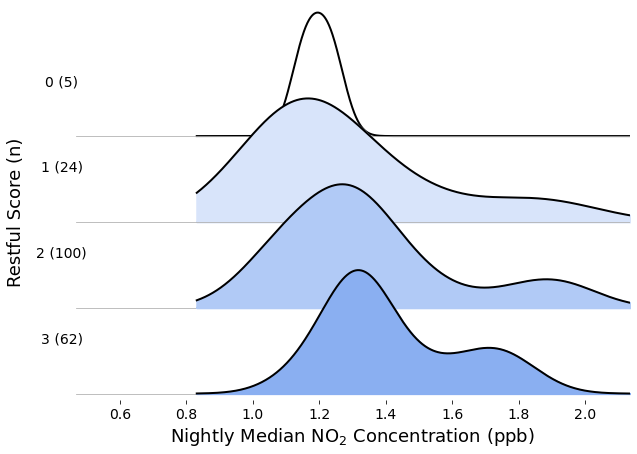

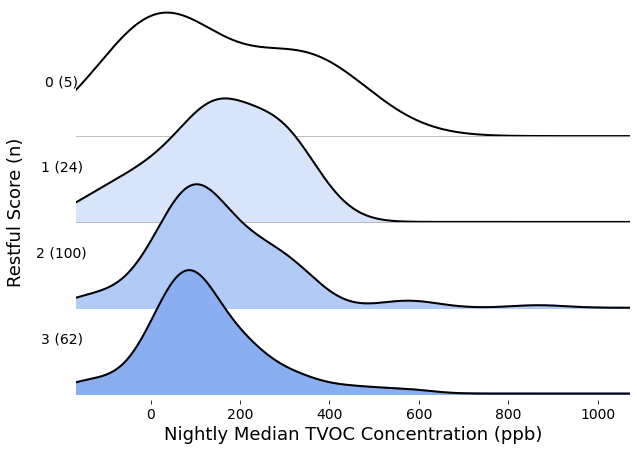

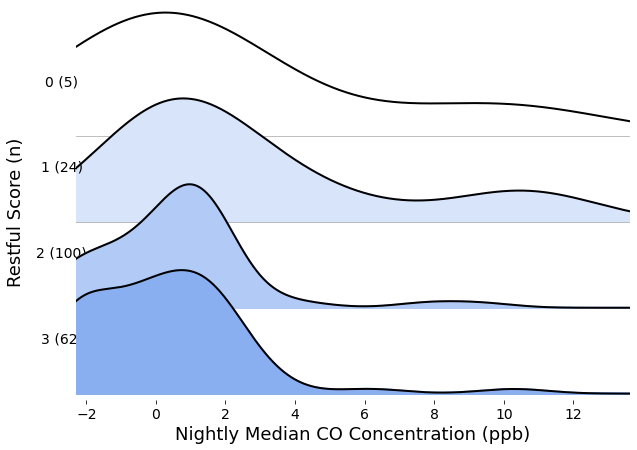

In [35]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co"]:
    plot_joyplot(ieq_and_bw_sleep, f"{pollutant}_median")

<div class="alert alert-block alert-success">
 
It looks like there is a relationship between the `restful` score and `co2` as well as `tvoc`. Rather than looking at the four scores, we could try lumping 0 and 1 together or just doing a positive/negative response.
    
</div>

### Analysis on Three-Point Scale
We can do some more interesting ANalaysis Of VAriance (ANOVA) on the three restfulness scores and see if there are significant differences between the distributions.

In [45]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co"]:
    pollutant_df = ieq_and_bw_sleep[[f"{pollutant}_median","restful_three"]]
    pollutant_df.dropna(subset=["restful_three"],inplace=True)
    grps = pd.unique(pollutant_df["restful_three"].values)
    d_data = {grp:pollutant_df[f"{pollutant}_median"][pollutant_df["restful_three"] == grp] for grp in grps}
    f, p = stats.f_oneway(d_data[1],d_data[2],d_data[3])
    for key in d_data.keys():
        li = d_data[key]
        print(np.std(li))

    m_comp = pairwise_tukeyhsd(endog=pollutant_df[f'{pollutant}_median'], groups=pollutant_df['restful_three'], alpha=0.05)
    print(m_comp)

380.13903338313077
339.7582260057754
308.6453082448054
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
   1.0    2.0 -229.3285 0.0045 -398.3876  -60.2693   True
   1.0    3.0  -348.442  0.001 -528.7723 -168.1118   True
   2.0    3.0 -119.1136 0.0788 -248.6836   10.4564  False
---------------------------------------------------------
0.2992222075739644
0.5483774222708506
0.36294218993682886

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower upper reject
------------------------------------------------
   1.0    2.0      nan 0.5566   nan   nan  False
   1.0    3.0      nan 0.5566   nan   nan  False
   2.0    3.0      nan 0.5566   nan   nan  False
------------------------------------------------
0.29143106452447554
0.3249578462031

### Violin Plots on Binary Restfulness Scores
By using the binary restfulness scores, we can create distributions of pollutants based on positive and negative restulfness scores.

In [33]:
def plot_restful_violin(df_in, pollutant="co2", save=False, save_dir="../reports/figures/beacon_ema"):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    df = df_in.copy()
    fig, ax = plt.subplots(figsize=(6,6))
    df["pollutant"] = pollutant
    violin_axes = sns.violinplot(x="pollutant",y=f"{pollutant}_median",hue="restful_binary",split=True,palette=["white","cornflowerblue"],data=df,ax=ax,cut=0,inner="quartile",)
    for loc in ["right","top","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    ax.set_ylabel(f"Nightly Median {visualize.get_pollutant_label(pollutant)} Concentration ({visualize.get_pollutant_units(pollutant)})",fontsize=18)
    plt.yticks(fontsize=14)
    ax.legend(title="Restful Response",ncol=1,frameon=False,title_fontsize=14,fontsize=12)

    low_vals = df[df["restful_binary"] == "Negative"]
    high_vals = df[df["restful_binary"] == "Positive"]
    _, p = stats.ttest_ind(low_vals[f"{pollutant}_median"],high_vals[f"{pollutant}_median"], equal_var=True)

    if p > 0:
        # Annotating with p-values
        xloc = ax.get_xticks()
        weight="bold" if p < 0.05 else "normal"
        ax.text(xloc-0.07,ax.get_ylim()[1],"p: ",fontsize=12,ha="center",va="bottom")
        ax.text(xloc,ax.get_ylim()[1],f"{round(p,3)}",fontsize=12,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{pollutant}-simplified_restful-violin.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

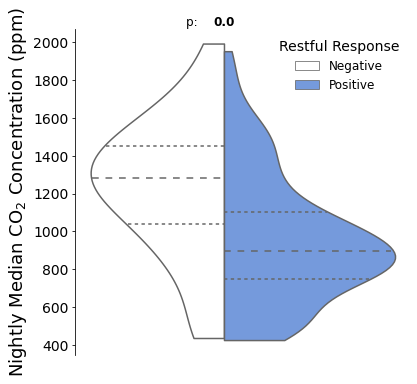

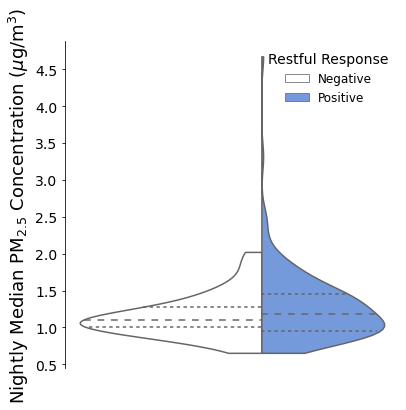

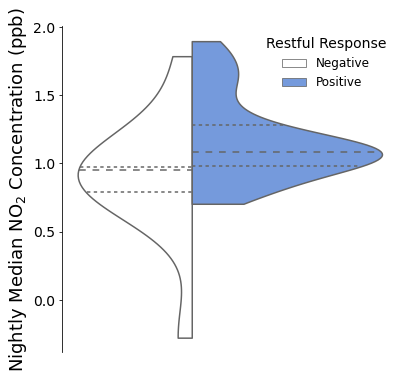

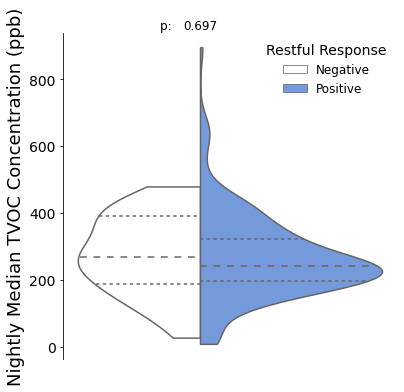

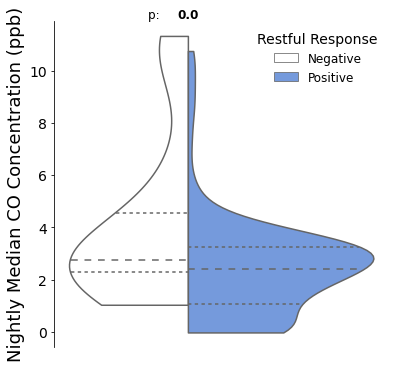

In [36]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co"]:
    plot_restful_violin(ieq_and_bw_sleep, pollutant=pollutant, save=False)

<div class="alert alert-block alert-success">
 
The `co2` concentration profiles are dramatically different for negative and positive `restful` scores.
    
</div>

# Ventilation and Sleep